In [248]:
import sys
import pandas as pd
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
geolocator = Nominatim()
from geopy.exc import GeocoderTimedOut
from urllib.request import urlopen
from twitterscraper import query_tweets
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import folium

E:\Anaconda220202\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [224]:
URL_INIT = 'https://twitter.com/'
state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
def parse_url(tweet_user):
    url = URL_INIT+ tweet_user.strip('@')
    return url

In [240]:
def triple_tweets_plot_us(t_df_1, t_df_2, t_df_3, keyword, save = False):
    list_of_found_userlocations = []
    tweets_df1 = pd.DataFrame(t.__dict__ for t in t_df_1)
    tweets_df2 = pd.DataFrame(t.__dict__ for t in t_df_2)
    tweets_df3 = pd.DataFrame(t.__dict__ for t in t_df_3)
    all_tweets_df = tweets_df1.append(tweets_df2).append(tweets_df3)
    list_of_users = all_tweets_df['username'].tolist()
    list_of_users = list(dict.fromkeys(list_of_users))
    for user in list_of_users:
        try:
            url = parse_url(user)
            response = urlopen(url)
        except:
            continue
        html = response.read()
        soup = BeautifulSoup(html, features="lxml")
        location_test = soup.find('span', {'class':'ProfileHeaderCard-locationText u-dir'})
        if location_test:
            location = str(soup.find('span', {'class':'ProfileHeaderCard-locationText u-dir'}).extract())[:-17].split("\n")[-1].lstrip()
        if location:
            try:
                located_location = geolocator.geocode(location, timeout=5)
                if located_location:
                    user_plus_location = (user, located_location)
                    list_of_found_userlocations.append(user_plus_location)
            except GeocoderTimedOut as e:
                print("Error: geocode failed on input %s with message %s"%(location, e))
    pd_location = pd.DataFrame(list_of_found_userlocations)
    lalist = []
    lolist = []
    for i in range(len(pd_location)):
        lalist.append(pd_location[1].iloc[i].latitude)
        lolist.append(pd_location[1].iloc[i].longitude)
    pd_location['latitude'] = lalist
    pd_location['longitude'] = lolist
    uloc = pd_location
    uloc.columns.values[0] = "username"
    uloc.columns.values[1] = "location"
    if save == True:
        uloc.to_csv("{0}_uloc.csv".format(keyword))
    t1 = t_uloc_join_tweet_plot(tweets_df1, uloc)
    t2 = t_uloc_join_tweet_plot(tweets_df2, uloc)
    t3 = t_uloc_join_tweet_plot(tweets_df3, uloc)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    norm = colors.Normalize(vmin=0, vmax=max([t1[('STATE', 'count')].max(), t2[('STATE', 'count')].max(), t3[('STATE', 'count')].max()])*1.1)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap='nipy_spectral')
    t1.plot(ax=ax1, column=('STATE', 'count'), cmap='nipy_spectral', legend=False, norm=norm)
    t2.plot(ax=ax2, column=('STATE', 'count'), cmap='nipy_spectral', legend=False, norm=norm)
    t3.plot(ax=ax3, column=('STATE', 'count'), cmap='nipy_spectral', legend=False, norm=norm)
    if tweets_df1.timestamp.min().date() == tweets_df1.timestamp.max().date():
        ax1.title.set_text(tweets_df1.timestamp.min().date())
        ax2.title.set_text(tweets_df2.timestamp.min().date())
        ax3.title.set_text(tweets_df3.timestamp.min().date())
    else:
        ax1.title.set_text('{0} - {1}'.format(tweets_df1.timestamp.min().date(), 
                                          tweets_df1.timestamp.max().date()))
        ax2.title.set_text('{0} - {1}'.format(tweets_df2.timestamp.min().date(), 
                                          tweets_df2.timestamp.max().date()))
        ax3.title.set_text('{0} - {1}'.format(tweets_df3.timestamp.min().date(), 
                                          tweets_df3.timestamp.max().date()))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.1, 0, 0.7, 0.05])
    fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal')
    fig.suptitle('number of #{0} tweets from a user with location in each state'.format(keyword), fontsize=20)
    
def t_uloc_join_tweet_plot(t, uloc, us_states = True):
    #uloc = pd.read_csv(uloc)
    t = t.merge(uloc, on='username', how='inner')
    t['latitude'] = t['latitude'].astype(float)
    t['longitude'] = t['longitude'].astype(float)
    t = gpd.GeoDataFrame(t, crs={'init': 'epsg:4326'}, geometry=gpd.points_from_xy(t.longitude, t.latitude))
    if us_states == True:
        t = t[t.location!= "United States"]
        t = gpd.sjoin(t, states_gdf, how="inner", op='within')
        t = t[['NAME', 'STATE']].groupby(['NAME']).agg(['count'])
        t = states_gdf.merge(t, on='NAME', how='left')
        t = t.to_crs('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +units=km')
    else:
        t = gpd.sjoin(t, world_gdf, how="inner", op='within')
        t = t[['name', 'iso_a3']].groupby(['name']).agg(['count'])
        t = world_gdf.merge(t, on='name', how='left')
    return t

In [163]:
'''
us_coronavirus_pdf['c'] = us_coronavirus_pdf[('STATE', 'count')]
us_coronavirus_pdf = us_coronavirus_pdf[['NAME','c']]
us_coronavirus_pdf.sample(5)
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=us_coronavirus_pdf,
    columns=['NAME', 'c'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of tweets'
).add_to(m)
folium.LayerControl().add_to(m)
m
'''

"\nus_coronavirus_pdf['c'] = us_coronavirus_pdf[('STATE', 'count')]\nus_coronavirus_pdf = us_coronavirus_pdf[['NAME','c']]\nus_coronavirus_pdf.sample(5)\nm = folium.Map(location=[48, -102], zoom_start=3)\nfolium.Choropleth(\n    geo_data=state_geo,\n    name='choropleth',\n    data=us_coronavirus_pdf,\n    columns=['NAME', 'c'],\n    key_on='feature.properties.name',\n    fill_color='YlGn',\n    fill_opacity=0.7,\n    line_opacity=0.2,\n    legend_name='Number of tweets'\n).add_to(m)\nfolium.LayerControl().add_to(m)\nm\n"

In [4]:
SocialDistanacing_0215_tweets = query_tweets(query = 'SocialDistancing', begindate=dt.date(2020,2,15), enddate = dt.date(2020,2,16))

INFO: queries: ['SocialDistancing since:2020-02-15 until:2020-02-16']
INFO: Got 68 tweets (68 new).


In [5]:
SocialDistanacing_0229_tweets = query_tweets(query = 'SocialDistancing', begindate=dt.date(2020,2,29), enddate = dt.date(2020,3,1))

INFO: queries: ['SocialDistancing since:2020-02-29 until:2020-03-01']
INFO: Got 425 tweets (425 new).


In [6]:
SocialDistanacing_0314_tweets = query_tweets(query = 'SocialDistancing', begindate=dt.date(2020,3,14), enddate = dt.date(2020,3,15))

INFO: queries: ['SocialDistancing since:2020-03-14 until:2020-03-15']
INFO: Got 12847 tweets (12847 new).


In [15]:
toiletpaper_0215_tweets = query_tweets(query = 'toiletpaper', begindate=dt.date(2020,2,15), enddate = dt.date(2020,2,16))

INFO: queries: ['toiletpaper since:2020-02-15 until:2020-02-16']
INFO: Got 2025 tweets (2025 new).


In [16]:
toiletpaper_0229_tweets = query_tweets(query = 'toiletpaper', begindate=dt.date(2020,2,29), enddate = dt.date(2020,3,1))

INFO: queries: ['toiletpaper since:2020-02-29 until:2020-03-01']
INFO: Got 3417 tweets (3417 new).


In [17]:
toiletpaper_0314_tweets = query_tweets(query = 'toiletpaper', begindate=dt.date(2020,3,14), enddate = dt.date(2020,3,15))

INFO: queries: ['toiletpaper since:2020-03-14 until:2020-03-15']
INFO: Got 13531 tweets (13531 new).


In [22]:
collision_0216_tweets = query_tweets(query = 'collision', begindate=dt.date(2020,2,13), enddate = dt.date(2020,2,20))

INFO: queries: ['collision since:2020-02-13 until:2020-02-14', 'collision since:2020-02-14 until:2020-02-15', 'collision since:2020-02-15 until:2020-02-16', 'collision since:2020-02-16 until:2020-02-17', 'collision since:2020-02-17 until:2020-02-18', 'collision since:2020-02-18 until:2020-02-19', 'collision since:2020-02-19 until:2020-02-20']
INFO: Got 1768 tweets (1768 new).
INFO: Got 3695 tweets (1927 new).
INFO: Got 5595 tweets (1900 new).
INFO: Got 7511 tweets (1916 new).
INFO: Got 9522 tweets (2011 new).
INFO: Got 11408 tweets (1886 new).
INFO: Got 13385 tweets (1977 new).


In [171]:
collision_0227_tweets = query_tweets(query = 'collision', begindate=dt.date(2020,2,27), enddate = dt.date(2020,3,5))

INFO: queries: ['collision since:2020-02-27 until:2020-02-28', 'collision since:2020-02-28 until:2020-02-29', 'collision since:2020-02-29 until:2020-03-01', 'collision since:2020-03-01 until:2020-03-02', 'collision since:2020-03-02 until:2020-03-03', 'collision since:2020-03-03 until:2020-03-04', 'collision since:2020-03-04 until:2020-03-05']
INFO: Got 1768 tweets (1768 new).
INFO: Got 3687 tweets (1919 new).
INFO: Got 5684 tweets (1997 new).
INFO: Got 7668 tweets (1984 new).
INFO: Got 9663 tweets (1995 new).
INFO: Got 11552 tweets (1889 new).
INFO: Got 13517 tweets (1965 new).


In [177]:
collision_0312_tweets = query_tweets(query = 'collision', begindate=dt.date(2020,3,12), enddate = dt.date(2020,3,19))

INFO: queries: ['collision since:2020-03-12 until:2020-03-13', 'collision since:2020-03-13 until:2020-03-14', 'collision since:2020-03-14 until:2020-03-15', 'collision since:2020-03-15 until:2020-03-16', 'collision since:2020-03-16 until:2020-03-17', 'collision since:2020-03-17 until:2020-03-18', 'collision since:2020-03-18 until:2020-03-19']
INFO: Got 1711 tweets (1711 new).
INFO: Got 3469 tweets (1758 new).
INFO: Got 5339 tweets (1870 new).
INFO: Got 7354 tweets (2015 new).
INFO: Got 9351 tweets (1997 new).
INFO: Got 11384 tweets (2033 new).
INFO: Got 13483 tweets (2099 new).


In [121]:
new_haircut_0214_tweets = query_tweets(query = 'new haircut', begindate=dt.date(2020,2,14), enddate = dt.date(2020,2,21))

INFO: queries: ['new haircut since:2020-02-14 until:2020-02-15', 'new haircut since:2020-02-15 until:2020-02-16', 'new haircut since:2020-02-16 until:2020-02-17', 'new haircut since:2020-02-17 until:2020-02-18', 'new haircut since:2020-02-18 until:2020-02-19', 'new haircut since:2020-02-19 until:2020-02-20', 'new haircut since:2020-02-20 until:2020-02-21']
INFO: Got 532 tweets (532 new).
INFO: Got 1126 tweets (594 new).
INFO: Got 1773 tweets (647 new).
INFO: Got 2429 tweets (656 new).
INFO: Got 3136 tweets (707 new).
INFO: Got 3848 tweets (712 new).
INFO: Got 4802 tweets (954 new).


In [65]:
new_haircut_0313_tweets = query_tweets(query = 'new haircut', begindate=dt.date(2020,3,13), enddate = dt.date(2020,3,20))

INFO: queries: ['new haircut since:2020-03-13 until:2020-03-14', 'new haircut since:2020-03-14 until:2020-03-15', 'new haircut since:2020-03-15 until:2020-03-16', 'new haircut since:2020-03-16 until:2020-03-17', 'new haircut since:2020-03-17 until:2020-03-18', 'new haircut since:2020-03-18 until:2020-03-19', 'new haircut since:2020-03-19 until:2020-03-20']
INFO: Got 490 tweets (490 new).
INFO: Got 991 tweets (501 new).
INFO: Got 1503 tweets (512 new).
INFO: Got 2003 tweets (500 new).
INFO: Got 2536 tweets (533 new).
INFO: Got 3127 tweets (591 new).
INFO: Got 3752 tweets (625 new).


In [88]:
new_haircut_0228_tweets = query_tweets(query = 'new haircut', begindate=dt.date(2020,2,28), enddate = dt.date(2020,3,6))

INFO: queries: ['new haircut since:2020-02-28 until:2020-02-29', 'new haircut since:2020-02-29 until:2020-03-01', 'new haircut since:2020-03-01 until:2020-03-02', 'new haircut since:2020-03-02 until:2020-03-03', 'new haircut since:2020-03-03 until:2020-03-04', 'new haircut since:2020-03-04 until:2020-03-05', 'new haircut since:2020-03-05 until:2020-03-06']
INFO: Got 547 tweets (547 new).
INFO: Got 1188 tweets (641 new).
INFO: Got 1843 tweets (655 new).
INFO: Got 2489 tweets (646 new).
INFO: Got 3159 tweets (670 new).
INFO: Got 3854 tweets (695 new).
INFO: Got 4479 tweets (625 new).


C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0

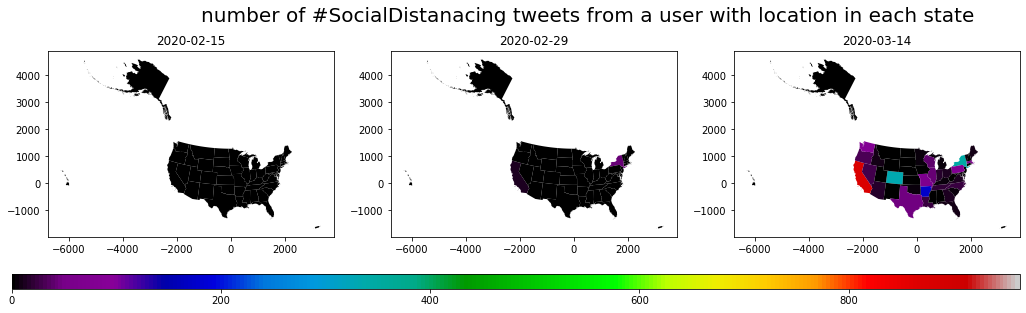

In [187]:
triple_tweets_plot_us(SocialDistanacing_0215_tweets, SocialDistanacing_0229_tweets, SocialDistanacing_0314_tweets, "SocialDistancing")

C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0

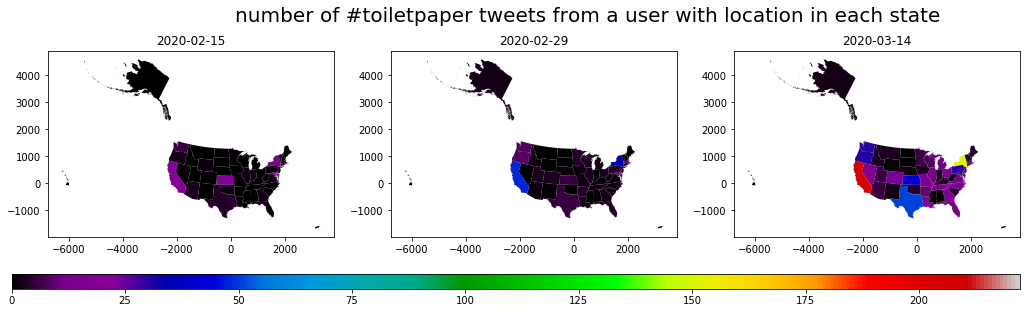

In [181]:
triple_tweets_plot_us(toiletpaper_0215_tweets, toiletpaper_0229_tweets, toiletpaper_0314_tweets, "toiletpaper")

C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0

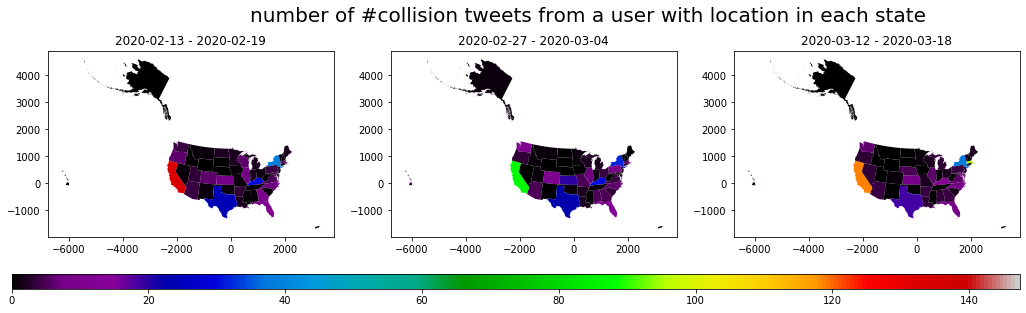

In [179]:
triple_tweets_plot_us(collision_0216_tweets, collision_0227_tweets, collision_0312_tweets, "collision")

C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0

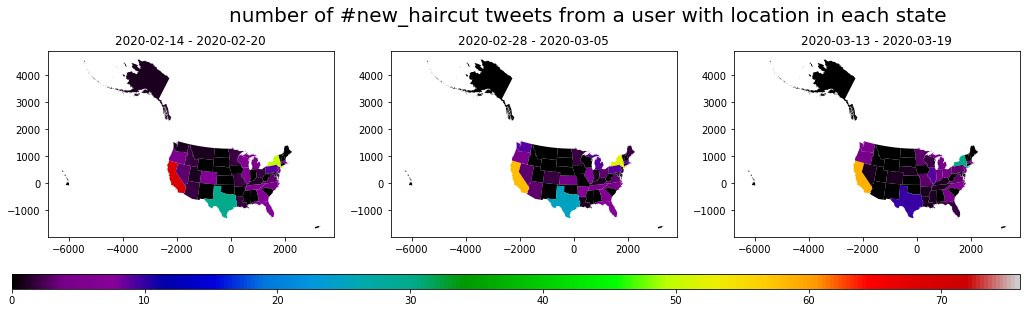

In [169]:
triple_tweets_plot_us(new_haircut_0214_tweets, new_haircut_0228_tweets, new_haircut_0313_tweets, "new_haircut")

In [242]:
def one_tweets_plot_world(t_df, keyword, save = False):
    list_of_found_userlocations = []
    tweets_df = pd.DataFrame(t.__dict__ for t in t_df)
    list_of_users = tweets_df['username'].tolist()
    list_of_users = list(dict.fromkeys(list_of_users))
    for user in list_of_users:
        try:
            url = parse_url(user)
            response = urlopen(url)
        except:
            continue
        html = response.read()
        soup = BeautifulSoup(html, features="lxml")
        location_test = soup.find('span', {'class':'ProfileHeaderCard-locationText u-dir'})
        if location_test:
            location = str(soup.find('span', {'class':'ProfileHeaderCard-locationText u-dir'}).extract())[:-17].split("\n")[-1].lstrip()
        if location:
            try:
                located_location = geolocator.geocode(location, timeout=5)
                if located_location:
                    user_plus_location = (user, located_location)
                    list_of_found_userlocations.append(user_plus_location)
            except GeocoderTimedOut as e:
                print("Error: geocode failed on input %s with message %s"%(location, e))
    pd_location = pd.DataFrame(list_of_found_userlocations)
    lalist = []
    lolist = []
    for i in range(len(pd_location)):
        lalist.append(pd_location[1].iloc[i].latitude)
        lolist.append(pd_location[1].iloc[i].longitude)
    pd_location['latitude'] = lalist
    pd_location['longitude'] = lolist
    uloc = pd_location
    uloc.columns.values[0] = "username"
    uloc.columns.values[1] = "location"
    if save == True:
        uloc.to_csv("{0}_uloc.csv".format(keyword))
    t = t_uloc_join_tweet_plot(tweets_df, uloc, us_states = False)
    fig, ax = plt.subplots(figsize=(20,10))
    norm = colors.Normalize(vmin=0, vmax=t[('iso_a3', 'count')].max()*1.1)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap='nipy_spectral')
    t.plot(ax=ax, column=('iso_a3', 'count'), cmap='nipy_spectral', legend=False, norm=norm)
    if tweets_df.timestamp.min().date() == tweets_df.timestamp.max().date():
        ax.title.set_text(tweets_df.timestamp.min().date())
    else:
        ax.title.set_text('{0} - {1}'.format(tweets_df.timestamp.min().date(), 
                                          tweets_df.timestamp.max().date()))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.1, 0, 0.7, 0.05])
    fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal')
    fig.suptitle('number of #{0} tweets from a user with location'.format(keyword), fontsize=20)

In [246]:
covid19slogan_tweets = query_tweets(query = 'I stay at work for you you stay at home for us', 
                                    begindate=dt.date(2020,3,15), 
                                    enddate = dt.date(2020,3,22))

INFO: queries: ['I stay at work for you you stay at home for us since:2020-03-15 until:2020-03-16', 'I stay at work for you you stay at home for us since:2020-03-16 until:2020-03-17', 'I stay at work for you you stay at home for us since:2020-03-17 until:2020-03-18', 'I stay at work for you you stay at home for us since:2020-03-18 until:2020-03-19', 'I stay at work for you you stay at home for us since:2020-03-19 until:2020-03-20', 'I stay at work for you you stay at home for us since:2020-03-20 until:2020-03-21', 'I stay at work for you you stay at home for us since:2020-03-21 until:2020-03-22']
INFO: Got 34 tweets (34 new).
INFO: Got 77 tweets (43 new).
INFO: Got 127 tweets (50 new).
INFO: Got 353 tweets (226 new).
INFO: Got 655 tweets (302 new).
INFO: Got 1004 tweets (349 new).
INFO: Got 1396 tweets (392 new).


C:\Users\OLLI-PEKKA\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda220202\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


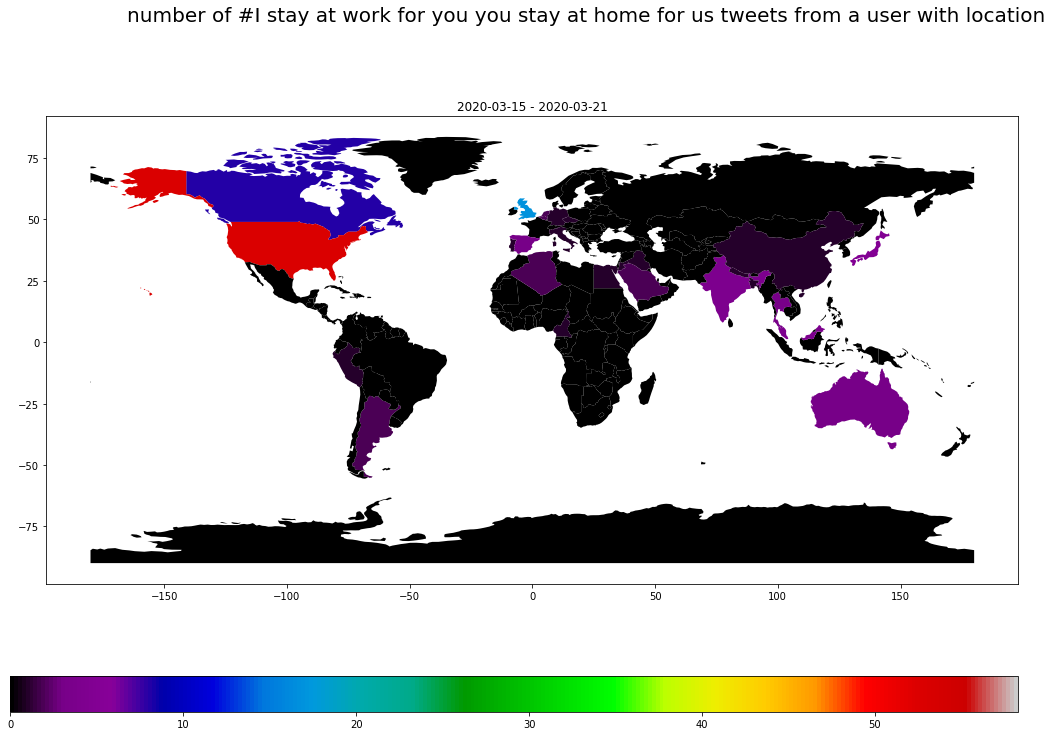

In [247]:
one_tweets_plot_world(covid19slogan_tweets, "I stay at work for you you stay at home for us", save = False)